## Notebook : Compute correlation and kinetic energy spectra using model grid data


In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

from scipy import signal

import crocosi.postp as pp
import phdequinox.croco_drifter as cdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=8)
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster


In [4]:
client

Client Scheduler: tcp://10.148.0.38:51236 Dashboard: http://10.148.0.38:8787/status,Cluster Workers: 42 Cores: 42 Memory: 719.88 GB


## Load data

In [5]:
#root_path = '/home1/scratch/aponte/'
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [6]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
r['surf'] = r['surf'].rename({'time_instant': 'time'})


In [99]:
V = ['u', 'v']
dij = 2
dti = 1
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 27 GB


In [100]:
ds = ds.chunk({'time': 'auto', 'x_rho': 'auto', 'x_u': 'auto', 'y_rho': 'auto', 'y_v': 'auto'})

In [8]:
x, y, t = 10, 10, 24*20
#x, y, t = -1, -1, -1
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [101]:
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:       (time: 72000, x_rho: 129, x_u: 129, y_rho: 361, y_v: 361)
Coordinates:
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * y_v           (y_v) float32 0.0 8000.0 16000.0 ... 2872000.0 2880000.0
    f_rho         (y_rho) float32 dask.array<chunksize=(361,), meta=np.ndarray>
  * y_rho         (y_rho) float32 -2000.0 6000.0 14000.0 ... 2870000.0 2878000.0
  * x_u           (x_u) float32 0.0 8000.0 16000.0 ... 1016000.0 1024000.0
  * time          (time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    f             (y_rho) float32 dask.array<chunksize=(361,), meta=np.ndarray>
  * x_rho         (x_rho) float32 -2000.0 6000.0 14000.0 ... 1014000.0 1022000.0
    x_v           (x_rho) float32 dask.array<chunksize=(129,), meta=np.ndarray>
    y_u           (y_rho) float32 dask.array<chunksize=(361,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
Data variables:
    u             (time, y_rho, x_u) float32 dask.array<chunksize=(2400, 323, 43), meta=np.ndarray>
    v             (time, y_v, x_rho) float32 dask.array<chunksize=(2400, 323, 43), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Feb-03 10:28:55 GMT
    uuid:         979d973b-3250-4199-96c2-7dff8e4f5076

In [10]:
from collections import OrderedDict

def _get_spatial_dims(v):
    """ Return an ordered dict of spatial dimensions in the s/z, y, x order
    """
    dims = OrderedDict( (d, next((x for x in v.dims if x[0]==d), None))
                        for d in ['s','y','x'] )
    return dims
def x2rho(v, grid,boundary):
    """ Interpolate from any grid to rho grid
    """
    dims = _get_spatial_dims(v)
    vout = v.copy()
    if dims['x'] == 'x_u':
        vout = grid.interp(vout, 'xi',boundary=boundary)
    if dims['y'] == 'y_v':
        vout = grid.interp(vout, 'eta',boundary=boundary)
    return vout

In [14]:
ds['u']

<xarray.DataArray 'u' (time: 72000, y_rho: 145, x_u: 52)>
dask.array<rechunk-merge, shape=(72000, 145, 52), dtype=float32, chunksize=(3600, 145, 26), chunktype=numpy.ndarray>
Coordinates:
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
    f_rho         (y_rho) float32 dask.array<chunksize=(145,), meta=np.ndarray>
  * y_rho         (y_rho) float32 -2000.0 18000.0 ... 2858000.0 2878000.0
  * x_u           (x_u) float32 0.0 20000.0 40000.0 ... 1000000.0 1020000.0
  * time          (time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    f             (y_rho) float32 dask.array<chunksize=(145,), meta=np.ndarray>
    y_u           (y_rho) float32 dask.array<chunksize=(145,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
Attributes:
    long_name:           u-momentum component
    units:               meter second-1
    online_operation:    instant
    interval_operation:  600 s
    interval_write:      600 s
    cell_methods:        time: point

In [11]:
for V in ['u','v']:
    ds[V] = x2rho(ds[V],r.xgrid,'extrapolate')

ValueError: conflicting sizes for dimension 'x_rho': length 53 on the data but length 258 on coordinate 'x_rho'

In [19]:
eulerian_field = xr.open_dataset(root_path+run+'diagnostics/Eulerian_field_ZC.nc').persist()

In [20]:
mean_zon = eulerian_field.mean('x_rho')

In [18]:
#ds['u']-mean_zon['u_mean']

<xarray.DataArray (time: 72000, y_rho: 722, x_rho: 258)>
dask.array<sub, shape=(72000, 722, 258), dtype=float32, chunksize=(72000, 722, 256), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * x_rho         (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
    f_rho         (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    f             (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>

---

## Spectra: manual computation

In [27]:
# utility functions

def get_spectra_E(x, fs=None, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=fs, axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def wrap_spectra(v, dt, f=None, **kwargs):
    v = v.chunk({'time': -1})
    _kwargs = {'fs': 1./dt}
    _kwargs.update(kwargs)
    if f is None:
        f, E = get_spectra_E(v.values, ufunc=False, **_kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(get_spectra_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': _kwargs['nperseg']}, kwargs=_kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

In [11]:
dt = float((ds.time[1]-ds.time[0]).values)
T = 20
N = int(T/dt/2)
binsize = 50

In [28]:
f, _ = wrap_spectra(ds.u.isel(x_rho=0,y_rho=0)+1j*ds.v.isel(x_rho=0,y_rho=0), dt, nperseg=N)
E = wrap_spectra(ds.u+1j*ds.v, dt, f=f, nperseg=N,detrend='linear')
E

<xarray.DataArray (y_rho: 145, x_rho: 52, freq_time: 2879)>
dask.array<getitem, shape=(145, 52, 2879), dtype=float64, chunksize=(10, 10, 2879), chunktype=numpy.ndarray>
Coordinates:
    f_rho         (y_rho) float32 dask.array<chunksize=(145,), meta=np.ndarray>
    f_u           (y_rho) float32 dask.array<chunksize=(145,), meta=np.ndarray>
    x_u           (x_rho) float32 dask.array<chunksize=(52,), meta=np.ndarray>
    y_u           (y_rho) float32 dask.array<chunksize=(145,), meta=np.ndarray>
    y_v           (y_rho) float32 dask.array<chunksize=(145,), meta=np.ndarray>
    x_v           (x_rho) float32 dask.array<chunksize=(52,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
  * x_rho         (x_rho) float32 -2000.0 18000.0 38000.0 ... 998000.0 1018000.0
  * y_rho         (y_rho) float32 -2000.0 18000.0 ... 2858000.0 2878000.0
    f_v           (y_rho) float32 dask.array<chunksize=(145,), meta=np.ndarray>
  * freq_time     (freq_time) float64 -71.97 -71.92 -71.87 ... 71.87 71.9

In [12]:
f, _ = wrap_spectra(ds.v.isel(x_rho=0,y_rho=0), dt, nperseg=N)
Ev = wrap_spectra(ds.v, dt, f=f, nperseg=N)

In [13]:
f, _ = wrap_spectra(ds.u.isel(x_rho=0,y_rho=0), dt, nperseg=N)
Eu = wrap_spectra(ds.u, dt, f=f, nperseg=N)

In [30]:
E_mean = E.mean('x_rho').persist()
#Ev_mean = Ev.mean('x_rho').persist()

In [15]:
Eu_mean = Eu.mean('x_rho').persist()
Ev_mean = Ev.mean('x_rho').persist()

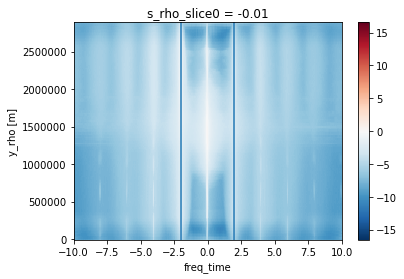

In [75]:
fig,ax = plt.subplots()
np.log10(E_mean).plot(ax=ax, x='freq_time', xlim=(-10,10))
ax.axvline(x=2.)
ax.axvline(x=-2.)

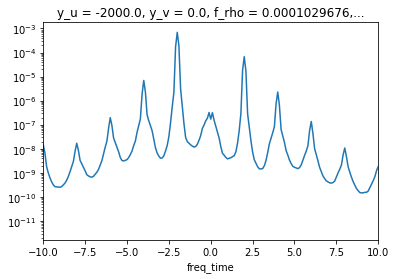

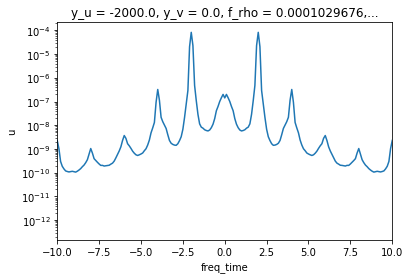

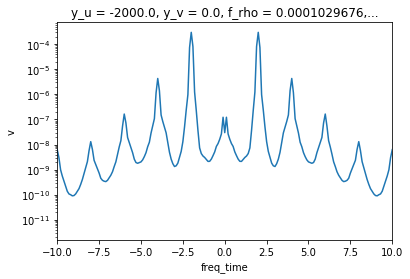

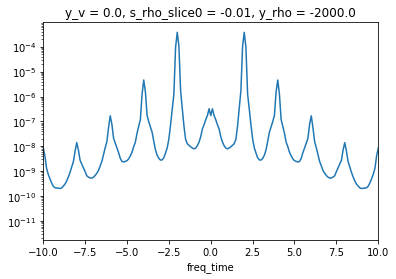

In [20]:
E_mean.sel(y_rho=725,method='nearest').plot(xlim=(-10,10),yscale='log')
plt.figure()
Eu_mean.sel(y_rho=725,method='nearest').plot(xlim=(-10,10),yscale='log')
plt.figure()
Ev_mean.sel(y_rho=725,method='nearest').plot(xlim=(-10,10),yscale='log')
plt.figure()
(Eu_mean.sel(y_rho=725,method='nearest')+Ev_mean.sel(y_rho=725,method='nearest')).plot(xlim=(-10,10),yscale='log')

In [ ]:
#Save data
#E_mean.attrs = {'Window' : T, 'Overlap' : 0.5, 'Fourier window' : 'hann', 'detrend' : 'linear'}
#E_mean = E_mean.chunk({'y_rho':-1,'freq_time':-1})
#name = 'Espectra_'+str(T)+'.nc'
#E_mean.to_netcdf('/home1/datawork/zcaspar/diags/'+name)

In [40]:
E_mean.sel(y_rho=1425e3,method='nearest')

<xarray.DataArray 'u' (freq_time: 2879)>
dask.array<getitem, shape=(2879,), dtype=float64, chunksize=(2879,), chunktype=numpy.ndarray>
Coordinates:
    s_rho_slice0  float32 -0.01
    f_rho         float32 dask.array<chunksize=(), meta=np.ndarray>
    y_rho         float32 1422000.0
    y_u           float32 dask.array<chunksize=(), meta=np.ndarray>
    f_u           float32 dask.array<chunksize=(), meta=np.ndarray>
  * freq_time     (freq_time) float64 -71.97 -71.92 -71.87 ... 71.87 71.92 71.97

---

## Spectra: xrft

---

## Decorrelations: manual apply_ufunc

In [102]:
# utility functions

def correlate_E(v1, v2, dt=None, roll=False, detrend=False, ufunc=True, **kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'same'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        _kwargs = {'mode': 'same', 'detrend': detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    vv = vv[...,int(vv.shape[-1]/2):]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0.5, detrend=True,**kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend==True:
            v1 = signal.detrend(v1)
            v2 = signal.detrend(v2)
        C+=[np.correlate(_v1, _v2, **kwargs)/Nr]
        i+=int((1-overlap)*Nr)
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)

In [103]:
def wrap_correlate(v1, v2, dt, lags=None, **kwargs):
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})
    if lags is None:
        lags, C = correlate_E(v1.values, v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        C = xr.apply_ufunc(correlate_E, v1, v2,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    output_sizes={'lags': lags.size}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [104]:
T = 20
dt = float((ds.time[1]-ds.time[0]).values)
_u = ds.v.isel(x_rho=slice(0,2),y_v=slice(0,2))
lags, _ = wrap_correlate(_u, _u, dt, roll=True, Nr=int(T/dt),detrend=True)

KeyboardInterrupt: 

In [98]:
Cvv = wrap_correlate(ds.v, ds.v, dt, lags=lags, roll=True,detrend=True, Nr=int(T/dt))
Cvv_mean = Cvv.mean('x_rho').compute()

KeyboardInterrupt: 

In [90]:
binsize = 50
y_bins = np.arange(0,2800*1e3,binsize*1e3)
Rvv_mean = Cvv_mean.groupby_bins('y_v',y_bins).mean()


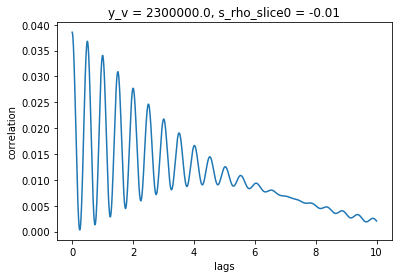

In [91]:
Cvv_mean.sel(y_v=2300*1e3,method='nearest').plot()

In [84]:
Rvv_mean = Rvv_mean.assign_coords({'y_v_bins':[yy.mid for yy in Rvv_mean.y_v_bins.values]}).rename({'y_v_bins':'y_bins'})
#Rvv_mean['y_bins'] = []

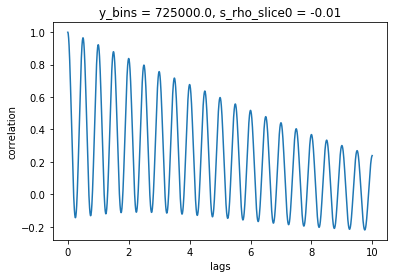

In [85]:
Rvv_norm = Rvv_mean/Rvv_mean.sel(lags=0)
Rvv_norm.sel(y_bins=700*1e3,method='nearest').plot()

In [29]:
_u = ds.u.isel(x_u=slice(0,2),y_rho=slice(0,2))
lags, _ = wrap_correlate(_u, _u, dt, roll=True, Nr=int(T/dt))

In [23]:
Cuu = wrap_correlate(ds.u, ds.u, dt, lags=lags, roll=True, Nr=int(T/dt))
Cuu_mean = Cuu.mean('x_rho').compute()

Exception ignored in: <function Run.__del__ at 0x2aaad967d7a0>
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/croco/crocosi/postp.py", line 73, in __del__
    self.ds[s].close()
KeyError: ('surf',)


In [24]:
Cuv = wrap_correlate(ds.u, ds.v, dt, lags=lags, roll=True, Nr=int(T/dt))
Cuv_mean = Cuv.mean('x_rho').compute()

In [28]:
Cvu = wrap_correlate(ds.v, ds.u, dt, lags=lags, roll=True, Nr=int(T/dt))
Cvu_mean = Cuv.mean('x_rho').compute()

In [32]:
C = Cuv_mean.to_dataset(name='Cuv')
C['Cuu']  =Cuu_mean
C['Cvv']  =Cvv_mean
C['Cvu']  =Cvu_mean

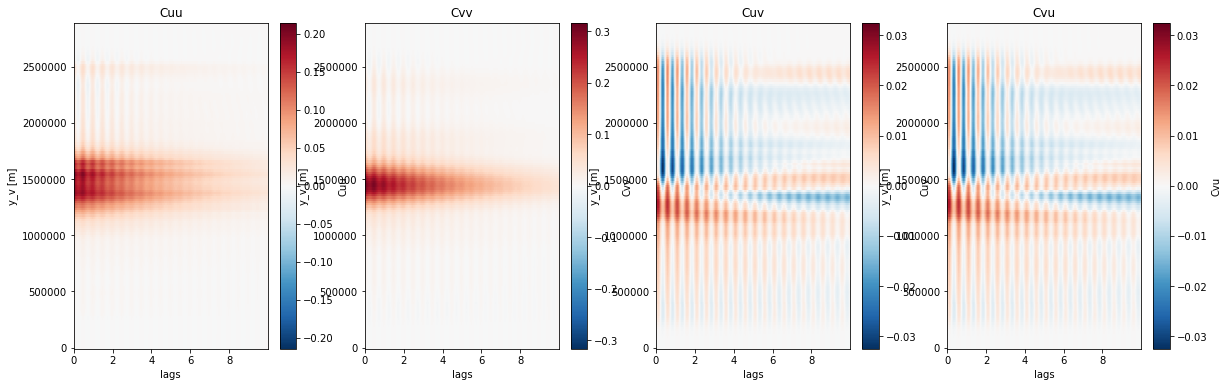

In [38]:
fig,axs =  plt.subplots(1,4,figsize=(20,6))
for ax,V in zip(axs,['Cuu','Cvv','Cuv','Cvu']):
    C[V].plot(y='y_rho',ax=ax,label=V)
    ax.set_title(V)

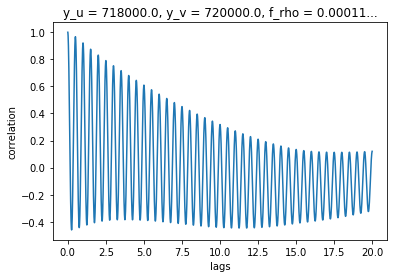

In [33]:
(Cuu_mean/Cuu_mean.sel(lags=0)).sel(y_rho=725*1000,method='nearest').plot.line(x='lags')

---

In [34]:
C.attrs = {'Window' : T, 'Overlap' : 0.5, 'Fourier window' : 'hann', 'detrend':'linear'}

C = C.chunk({'y_rho':-1})

In [36]:
#Save data
name = 'Ecorr_'+str(T)+'.nc'
C.to_netcdf('/home1/datawork/zcaspar/diags/'+name)

In [105]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
